In [1]:
import pymc3 as pm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
x1 = np.random.normal(300, 25, 1000)
x2 = np.random.normal(297, 25, 1000)


In [3]:
def setup_priors(data):
    ''' setup priors. takes in combined populations as input'''
    priors = dict()

    # Setup our priors
    lower = np.var(data)/1000.0
    upper = np.var(data)*1000

    v = pm.Exponential("nu", beta=1.0/29) + 1
    tau = 1.0/np.var(data)/1000.0
    mu1 = pm.Normal('mu1', mu=np.mean(data), tau=tau)
    var1 = pm.Uniform('var1', lower=lower, upper=upper)

    mu2 = pm.Normal('mu2', mu=np.mean(data), tau=tau)
    var2 = pm.Uniform('var2', lower=lower, upper=upper)

    priors['mu1'] = mu1
    priors['var1'] = var1
    priors['mu2'] = mu2
    priors['var2'] = var2
    priors['v'] = v
    
    return priors

In [4]:
def generate_models(values, values2, priors):
    '''generate models based on priors and given samples'''
    v = priors['v']
    mu1 = priors['mu1']
    var1 = priors['var1']
    lam1 = 1.0/var1

    mu2 = priors['mu2']
    var2 = priors['var2']
    lam2 = 1.0/var2

    # Include our observed data into the model
    t1 = pm.NoncentralT("t1", mu=mu1, lam=lam1, nu=v, value=values, observed=True)
    t2 = pm.NoncentralT("t2", mu=mu2, lam=lam2, nu=v, value=values2, observed=True)
    # Push our priors into a model
    model = pm.Model([t1, mu1, var1, t2, mu2, var2, v])
    
    return model

In [17]:
with pm.Model() as sp_model:
    data = np.concatenate((x1, x2), axis=0)
    ''' setup priors. takes in combined populations as input'''
    priors = dict()

    # Setup our priors
    lower = np.var(data)/1000.0
    upper = np.var(data)*1000

    v = pm.Exponential("nu", beta=1.0/29) + 1
    tau = 1.0/np.var(data)/1000.0
    mu1 = pm.Normal('mu1', mu=np.mean(data), tau=tau)
    var1 = pm.Uniform('var1', lower=lower, upper=upper)

    mu2 = pm.Normal('mu2', mu=np.mean(data), tau=tau)
    var2 = pm.Uniform('var2', lower=lower, upper=upper)

    priors['mu1'] = mu1
    priors['var1'] = var1
    priors['mu2'] = mu2
    priors['var2'] = var2
    priors['v'] = v
    
    print(priors)

TypeError: __init__() missing 1 required positional argument: 'lam'

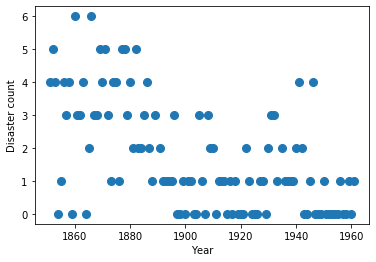

In [14]:
import pandas as pd
disaster_data = pd.Series([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                           3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                           2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
                           1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                           0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                           3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                           0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
years = np.arange(1851, 1962)

plt.plot(years, disaster_data, 'o', markersize=8);
plt.ylabel("Disaster count")
plt.xlabel("Year");

In [18]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.8


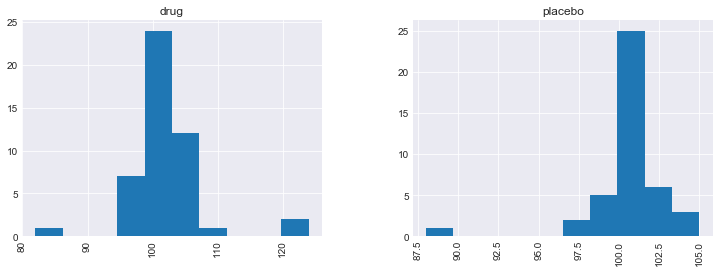

In [19]:
drug = (101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101)
placebo = (99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99)

y1 = np.array(drug)
y2 = np.array(placebo)
y = pd.DataFrame(dict(value=np.r_[y1, y2], group=np.r_[['drug']*len(drug), ['placebo']*len(placebo)]))

y.hist('value', by='group', figsize=(12, 4));

In [21]:
μ_m = y.value.mean()
μ_s = y.value.std() * 2

with pm.Model() as model:
    group1_mean = pm.Normal('group1_mean', mu=μ_m, sd=μ_s)
    group2_mean = pm.Normal('group2_mean', mu=μ_m, sd=μ_s)

In [22]:
σ_low = 1
σ_high = 10

with model:
    group1_std = pm.Uniform('group1_std', lower=σ_low, upper=σ_high)
    group2_std = pm.Uniform('group2_std', lower=σ_low, upper=σ_high)

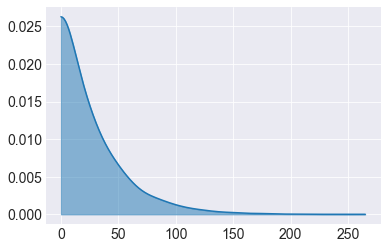

In [23]:
with model:
    ν = pm.Exponential('ν_minus_one', 1/29.) + 1

pm.kdeplot(np.random.exponential(30, size=10000), fill_kwargs={'alpha': 0.5});

In [24]:
with model:
    λ1 = group1_std**-2
    λ2 = group2_std**-2

    group1 = pm.StudentT('drug', nu=ν, mu=group1_mean, lam=λ1, observed=y1)
    group2 = pm.StudentT('placebo', nu=ν, mu=group2_mean, lam=λ2, observed=y2)

In [25]:
with model:
    diff_of_means = pm.Deterministic('difference of means', group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group1_std - group2_std)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2))

In [26]:
with model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]
Sampling 4 chains, 0 divergences: 100%|█████████████████████████████████████| 10000/10000 [00:09<00:00, 1038.52draws/s]


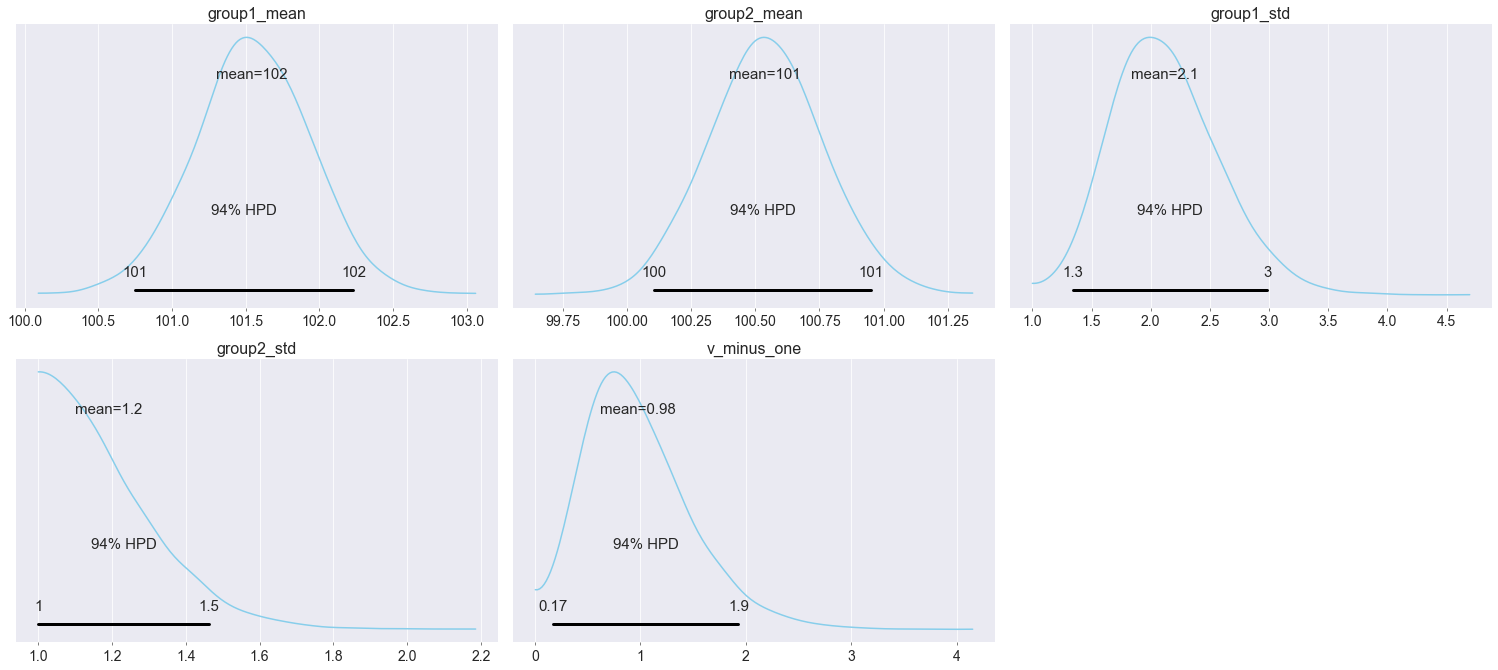

In [27]:
pm.plot_posterior(trace, var_names=['group1_mean','group2_mean', 'group1_std', 'group2_std', 'ν_minus_one'],
                  color='#87ceeb');

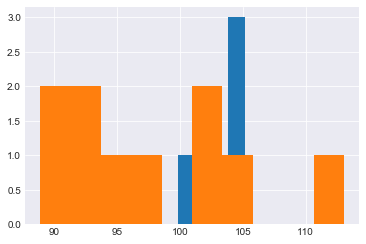

C:\Users\Rahul\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:62: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


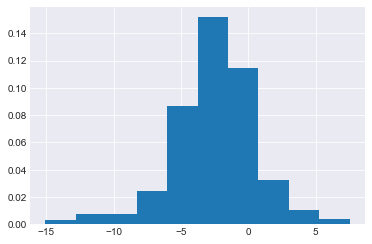

In [31]:
import numpy as np
from pylab import plt

def dnorm(x, mu, sig):
    return 1/(sig * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * sig**2))

def dexp(x, l):
    return l * np.exp(- l*x)

def like(parameters):
    [mu1, sig1, mu2, sig2] = parameters
    return dnorm(sample1, mu1, sig1).prod()*dnorm(sample2, mu2, sig2).prod()

def prior(parameters):
    [mu1, sig1, mu2, sig2] = parameters
    return dnorm(mu1, pooled.mean(), 1000*pooled.std()) * dnorm(mu2, pooled.mean(), 1000*pooled.std()) * dexp(sig1, 0.1) * dexp(sig2, 0.1)

def posterior(parameters):
    [mu1, sig1, mu2, sig2] = parameters
    return like([mu1, sig1, mu2, sig2])*prior([mu1, sig1, mu2, sig2])


#create samples
sample1 = np.random.normal(100, 3, 8)
sample2 = np.random.normal(100, 7, 10)

pooled= np.append(sample1, sample2)

plt.figure(0)
plt.hist(sample1)
plt.hist(sample2)
plt.show(block=False)

mu1 = 100 
sig1 = 10
mu2 = 100
sig2 = 10
parameters = np.array([mu1, sig1, mu2, sig2])

niter = 10000

results = np.zeros([niter, 4])
results[1,:] = parameters

for iteration in np.arange(2,niter):
    candidate = parameters + np.random.normal(0,0.5,4)
    ratio = posterior(candidate)/posterior(parameters)
    if np.random.uniform() < ratio:
        parameters = candidate
    results[iteration,:] = parameters

#burn-in
results = results[499:niter-1,:]



In [35]:
mu1 = results[:,1]
mu2 = results[:,3]

d = (mu1 - mu2)
p_value = np.mean(d > 0)

p_value

0.17094736842105263

In [ ]:
plt.figure(1)
plt.hist(d,normed = 1)
plt.show()

In [ ]:
https://stats.stackexchange.com/questions/130389/bayesian-equivalent-of-two-sample-t-test
    https://github.com/strawlab/best
        https://medium.com/@rnbrown/bayesian-estimation-with-pymc3-9906a5214618
            http://www.sumsar.net/blog/2014/02/bayesian-first-aid-one-sample-t-test/
                https://docs.pymc.io/notebooks/BEST.html